In [74]:
import numpy as np
import uproot
import aiohttp
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

In [75]:
stuff = np.random.normal( loc=[1.1, 1.8], scale=[0.8,0.5], size=(100000, 2) )

In [76]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(tf.config.list_physical_devices('GPU'))

['/device:CPU:0']
[]


In [77]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]


In [78]:
#print(stuff.shape)
#plt.hist2d( stuff[:,0], stuff[:,1] )

In [79]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[]


In [82]:
def synthroot(filename, data, data2):
    with uproot.recreate(filename) as file:
        file["testree"] = {"theta0": data, "theta_unknown_S": data2}
        file["twotree"] = {"theta0Z": data, "thetaUS": data2}


In [118]:
N = 10**5
n = 4  # dimensions of observables

# Synthetic
theta0_G = np.column_stack((
    np.random.normal(1.1, 0.8, N),   # 1st dimension (normal)
    np.random.normal(1.8, 0.5, N),   # 2nd dimension (normal)
    np.random.normal(0.5, 0.2, N),   # 3rd dimension (normal)
    np.random.laplace(2, 12, N)
    #np.random.laplace(3, N)          # 4th dimension (Laplace ;^)
))

theta0_S = np.random.normal(0, 0.5, (N, n)) + theta0_G  # Detector smearing for synthetic sample but different

theta0t = np.stack((theta0_G, theta0_S), axis=1)  # axis=1 to maintain stack property

print("Shape theta0_G:", theta0_G.shape)
print("Shape theta0:", theta0t.shape)

# Natural
theta_unknown_G = np.column_stack([
    np.random.normal(1, .5, N),       # First dimension
    np.random.normal(1.5, .3, N),     # Second dimension
    np.random.normal(0.3, .1, N),     # 3rd dimension (normal)
    np.random.laplace(1.8, 11.6, N)         # 4th dimension (Laplace ;^)
])

theta_unknown_St = np.random.normal(0, 0.5, (N, n)) + theta_unknown_G

# Save data to a fake ROOT file
synthroot("synth_data3.root", theta0t, theta_unknown_St)

#Root file path
rootfile = "synth_data3.root"


Shape theta0_G: (100000, 4)
Shape theta0: (100000, 2, 4)


In [9]:
testroot = uproot.open("https://scikit-hep.org/uproot3/examples/Zmumu.root")
print(testroot.keys())

['events;1']


In [119]:
#General root file opened in jetdata
jetdata = uproot.open(rootfile)
print(jetdata.keys())
jetdata['testree']

events = []

for key in jetdata.keys():
    microevent = []
    jetdata[key].show()
    #microevent.extend(jetdata[key].keys())
    #events.append(microevent)
    #events.append(*jetdata[key].keys())
    print("---next key data---")

#events = jetdata['testree'] #uproot.open("synth_data.root:testree")
#events.show()
#print(events.keys())
print(jetdata['testree'].keys())
print(events) 


['testree;1', 'twotree;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
theta0               | double[2][4]             | AsDtype("('>f8', (2, 4))")
theta_unknown_S      | double[4]                | AsDtype("('>f8', (4,))")
---next key data---
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
theta0Z              | double[2][4]             | AsDtype("('>f8', (2, 4))")
thetaUS              | double[4]                | AsDtype("('>f8', (4,))")
---next key data---
['theta0', 'theta_unknown_S']
[]


In [15]:
print("Shape theta0c_G:", theta0_G.shape)
print("Shape 0_S:", theta0_S.shape)
print("Shape theta0:", theta0t.shape)
print("Shape unknown s:", theta_unknown_St.shape)
#print("Shape theta0 Tree:", events["theta0"].array(library="np").shape)
#print("Shape unknown s Tree:", events["theta_unknown_S"].array(library="np").shape)

theta0 = events["theta0"].array(library="np")
theta_unknown_S = events["theta_unknown_S"].array(library="np")

Shape theta0c_G: (100000, 4)
Shape 0_S: (100000, 4)
Shape theta0: (100000, 2, 4)
Shape unknown s: (100000, 4)


TypeError: list indices must be integers or slices, not str

(array([3.000e+00, 8.000e+00, 1.000e+01, 1.300e+01, 1.400e+01, 1.200e+01,
        1.100e+01, 1.900e+01, 2.300e+01, 2.200e+01, 2.900e+01, 2.600e+01,
        3.800e+01, 4.000e+01, 5.800e+01, 6.300e+01, 6.700e+01, 7.400e+01,
        9.200e+01, 1.010e+02, 1.110e+02, 1.320e+02, 1.560e+02, 1.640e+02,
        1.820e+02, 2.450e+02, 2.660e+02, 2.790e+02, 3.270e+02, 3.850e+02,
        4.330e+02, 5.400e+02, 5.960e+02, 6.940e+02, 7.230e+02, 8.530e+02,
        9.860e+02, 1.142e+03, 1.279e+03, 1.362e+03, 1.788e+03, 1.943e+03,
        2.151e+03, 2.587e+03, 2.823e+03, 3.355e+03, 3.773e+03, 4.406e+03,
        5.024e+03, 5.754e+03, 6.414e+03, 6.063e+03, 5.285e+03, 4.676e+03,
        4.095e+03, 3.566e+03, 3.114e+03, 2.726e+03, 2.376e+03, 2.097e+03,
        1.803e+03, 1.603e+03, 1.344e+03, 1.212e+03, 1.092e+03, 9.490e+02,
        7.880e+02, 6.840e+02, 6.250e+02, 5.280e+02, 4.730e+02, 3.920e+02,
        3.860e+02, 3.160e+02, 2.760e+02, 2.350e+02, 2.180e+02, 1.520e+02,
        1.600e+02, 1.360e+02, 1.010e+0

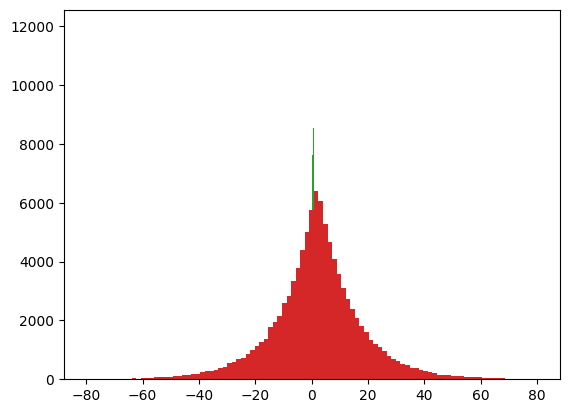

In [127]:
plt.hist( theta0_G[:,0], bins=np.linspace(-3,3, 100) )
plt.hist( theta0_G[:,1], bins=np.linspace(-3,4, 100) )
plt.hist( theta0_G[:,2], bins=np.linspace(-3,3, 100) )
plt.hist( theta0_G[:,3], bins=np.linspace(-80,80, 100) )


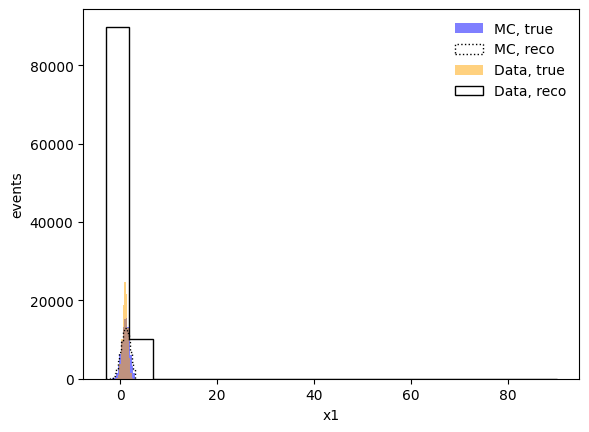

In [128]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S[:,0],bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_St[:,0],bins=np.linspace(-3,90,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x1")
plt.ylabel("events")
plt.legend(frameon=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


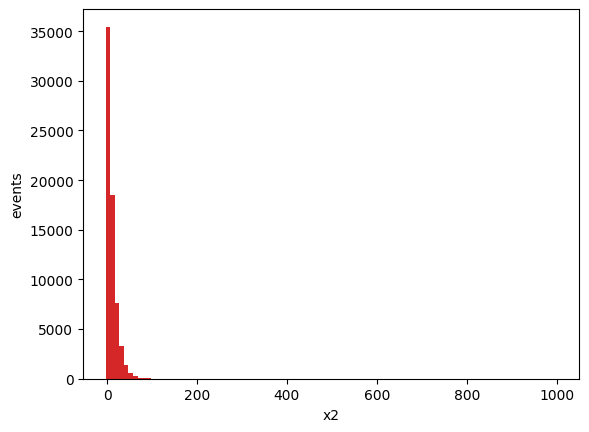

In [130]:
plt.hist( theta_unknown_G[:,0], bins=np.linspace(-3,3, 100) )
plt.hist( theta_unknown_G[:,1], bins=np.linspace(-3,4, 100) )
plt.hist( theta_unknown_G[:,2], bins=np.linspace(-3,3, 100) )
plt.hist( theta_unknown_G[:,3], bins=np.linspace(-3,1000, 100) )
plt.xlabel("x2")
plt.ylabel("events")
plt.legend(frameon=False)


In [25]:
# # test 4d
# np.random.seed(42)
# a = np.random.randint(0, 5, 100)
# b = np.random.randint(0, 5, 100)
# c = np.random.rand(100)
# d = np.random.rand(100)

# fig, axs = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         #filter
#         mask = (a == i) & (b == j)
#         current_c = c[mask]
#         current_d = d[mask]

#         #scatter in sub
#         axs[i, j].scatter(current_c, current_d, s=10)

#         #labels
#         axs[i, j].set_xlabel('c')
#         axs[i, j].set_ylabel('d')

#         #title
#         axs[i, j].set_title(f'a={i}, b={j}')

# plt.tight_layout()
# plt.show()


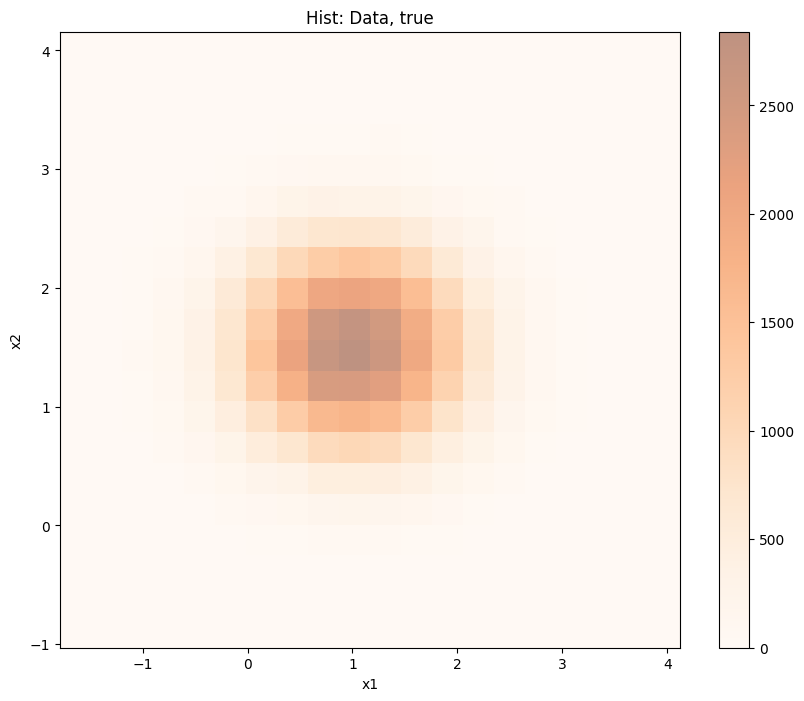

In [102]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(theta_unknown_St[:, 0], theta_unknown_St[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Hist: Data, true")
plt.show()

In [27]:
# #Data, true
# theshape=theta_unknown_S.shape
# print(theshape)
# N = theshape[0] * theshape[1]
# plt.figure(figsize=(10, 8))
# plt.hist(theta_unknown_S.reshape(N), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.show()

In [28]:
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# _, _, _ = plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# _, _, _ = plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()


In [131]:
inputs = Input((4,))  # 4D input
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [132]:
myweights = of.omnifold(theta0t,theta_unknown_St,25,model)

theta0G (100000, 4), labels (100000,), labels unknown (100000,), theta 0(100000, 2, 4), theta unknown s(100000, 4)
10/10 [==============================] - 0s 5ms/step


In [133]:
# #needless
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), cmap='Blues', alpha=0.5, label="MC, true")
# plt.hist2d(theta_unknown_G[:, 0], theta_unknown_G[:, 1], bins=(20, 20), cmap='Oranges', alpha=0.5, label="Data, true")
# plt.hist2d(theta0_G[:, 0], theta0_G[:, 1], bins=(20, 20), weights=myweights[-1, 0, :], cmap='Greys', alpha=0.5, label="OmniFolded")
# plt.xlabel("x1")
# plt.ylabel("x2")
# plt.legend(frameon=False)
# plt.show()

In [134]:
print("Shape theta0_G:", theta0_G.shape)
print("Shape weights:", myweights.shape)


Shape theta0_G: (100000, 4)
Shape weights: (25, 2, 100000)


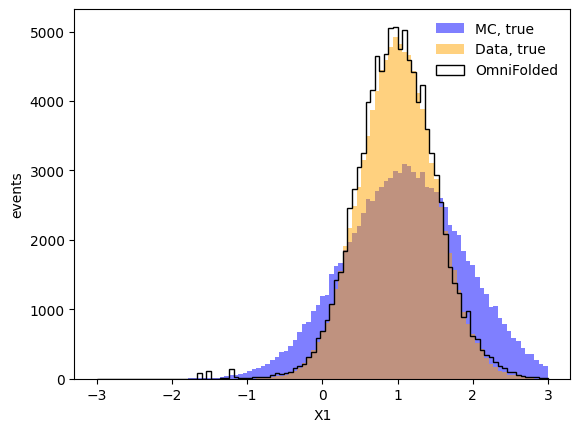

In [193]:
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,100),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G[:,0],bins=np.linspace(-3,3,100),color=['orange'],alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G[:,0],bins=np.linspace(-3,3,100),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X1")
plt.ylabel("events")
plt.legend(frameon=False)

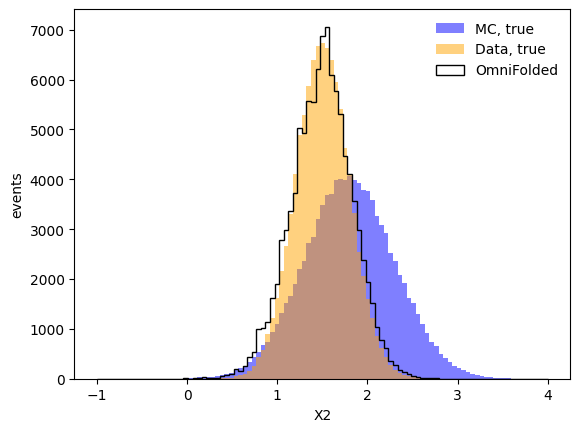

In [192]:
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-1,4,100),color=['blue'],alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G[:,1],bins=np.linspace(-1,4,100),color=['orange'],alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G[:,1],bins=np.linspace(-1,4,100),weights=myweights[-1, 0, :],color='black',histtype="step",label="OmniFolded")
plt.xlabel("X2")
plt.ylabel("events")
plt.legend(frameon=False)

In [21]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,0],theta_unknown_G[:,0], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()

In [22]:
# Draw the response matrix    
# plt.figure(1)
# G, xbins2d, ybins2d, patches2d = plt.hist2d(theta_unknown_S[:,1],theta_unknown_G[:,1], bins=np.linspace(-1,2,20), weights=myweights[0, -1, :], cmap='Blues')
# plt.xlabel('True')
# plt.ylabel('Reco')
# plt.colorbar()